In [217]:
## Compose portfolio list based on "election news" outcomes
## Get Historical Datas of ETF or STK from YHfinance

import yfinance as yf
import pandas as pd

## 2008 - 2016 election 
#DEM : GOOGL, GS
#REP : CVX, LMT
##2020 election 
#DEM : NFLX, MSFT    
#REP : ORCL, TGNA
##2024 election
#DEM : NFLX, AAPL 
#REP : DJT, TSLA 


BEF2020DEMSTK=['GOOGL','GS']
BEF2020REPSTK=['CVX', 'LMT']
E2020DEMSTK= ['NFLX','MSFT']
E2020REPSTK=['ORCL','TGNA']
E2024DEMSTK=['NFLX', 'AAPL']
E2024REPSTK=['DJT','TSLA']

In [218]:
# Load polls_by_cycle saved from poll.ipynb


from pathlib import Path



polls_by_cycle = {}
poll_dir = Path("../data/polls_by_cycle")
for csv_path in sorted(poll_dir.glob("*poll.csv")):
    key = csv_path.stem
    df = pd.read_csv(csv_path, parse_dates=[0], index_col=0)
    polls_by_cycle[key] = df

print(f"Loaded {len(polls_by_cycle)} poll cycles from {poll_dir}")


Loaded 15 poll cycles from ../data/polls_by_cycle


In [219]:
# Exit/Re-entry signal dates (signal date + next poll day as trading date)
EXIT_MA_DAYS = 5
EXIT_THRESHOLD = 5.0
REENTRY_MA_DAYS = 3
REENTRY_THRESHOLD = 4.0


def dedupe_runs(signal_dates, poll_index):
    if len(signal_dates) == 0:
        return pd.DatetimeIndex([])
    signal_dates = signal_dates.sort_values()
    pos = pd.Index(poll_index).get_indexer(signal_dates)
    deduped = [signal_dates[0]]
    for i in range(1, len(signal_dates)):
        if pos[i] != pos[i - 1] + 1:
            deduped.append(signal_dates[i])
    return pd.DatetimeIndex(deduped)


def next_poll_day(dates, poll_index):
    next_days = []
    for d in dates:
        p = poll_index.searchsorted(d, side='right')
        if p < len(poll_index):
            next_days.append(poll_index[p])
        else:
            next_days.append(pd.NaT)
    return pd.DatetimeIndex(next_days)


signal_table = {}
for y in [2016, 2020, 2024]:
    poll_df = polls_by_cycle.get(f"{y}poll")
    if poll_df is None or poll_df.empty or 'margin' not in poll_df.columns:
        continue
    poll_df = poll_df.copy()
    poll_df.index = pd.to_datetime(poll_df.index)
    idx = poll_df.index

    exit_ma = poll_df['margin'].rolling(EXIT_MA_DAYS, min_periods=1).mean()
    exit_signals = exit_ma[exit_ma >= EXIT_THRESHOLD].index
    exit_dedup = dedupe_runs(exit_signals, idx)
    exit_next = next_poll_day(exit_dedup, idx)

    reentry_ma = poll_df['margin'].rolling(REENTRY_MA_DAYS, min_periods=1).mean()
    reentry_signals = reentry_ma[reentry_ma <= REENTRY_THRESHOLD].index
    reentry_dedup = dedupe_runs(reentry_signals, idx)
    reentry_next = next_poll_day(reentry_dedup, idx)

    rows = []
    for d, nd in zip(exit_dedup, exit_next):
        rows.append({'signal_date': d, 'trading_date': nd, 'signal_type': 'exit'})
    for d, nd in zip(reentry_dedup, reentry_next):
        rows.append({'signal_date': d, 'trading_date': nd, 'signal_type': 'reentry'})
    df = pd.DataFrame(rows).sort_values('signal_date')
    signal_table[y] = df

for y, df in signal_table.items():
    print(f"{y} signal dates")
    display(df)



2016 signal dates


,signal_date,trading_date,signal_type
0,2016-03-06,2016-03-07,exit
4,2016-05-10,2016-05-11,reentry
1,2016-06-13,2016-06-14,exit
5,2016-07-04,2016-07-05,reentry
6,2016-07-07,2016-07-08,reentry
2,2016-08-03,2016-08-04,exit
7,2016-09-02,2016-09-03,reentry
3,2016-10-10,2016-10-11,exit
8,2016-11-06,2016-11-07,reentry


2020 signal dates


,signal_date,trading_date,signal_type
2,2020-02-27,2020-02-28,reentry
0,2020-03-09,2020-03-10,exit
3,2020-04-13,2020-04-14,reentry
1,2020-04-21,2020-04-22,exit


2024 signal dates


,signal_date,trading_date,signal_type
0,2024-09-13,2024-09-14,reentry


In [220]:
## Entry/exit config and key dates 

EXPIRY_MONTH = 9
ENTRY_OFFSET_DAYS = 1   # next trading day after expiry
EXIT_OFFSET_DAYS = 1    # exit at election_date + N days
ENTRY_PRICE_COL = 'Latest'  # option price column: Open/Latest
EXIT_PRICE_COL = 'Latest'   # option price column: Open/Latest
POLL_HOLD_PRICE_COL = 'Latest'  # poll-rule hold price column: Open/Latest
SIGNAL_PRICE_COL = 'Open'  # exit/reentry execution price column: Open/Latest
POLL_PRICE_COL = POLL_HOLD_PRICE_COL
REENTRY_PRICE_COL = SIGNAL_PRICE_COL

events = pd.read_csv("../data/events.csv", parse_dates=["date"])

exps = events.loc[
    (events["event_type"] == "us_equity_options_expiry")
    & (events["date"].dt.year.between(2008, 2024))
    & (events["date"].dt.month == EXPIRY_MONTH),
    ["year", "date", "event_type"],
].reset_index(drop=True)

events["election_date"] = pd.to_datetime(events["election_date"])
events["date"] = pd.to_datetime(events["date"])

elecs = events.loc[
    (events["event_type"] == "election_window")
    & (events["date"].dt.normalize() == events["election_date"].dt.normalize())
    & (events["date"].dt.year.between(2008, 2024)),
    ["year", "election_date", "event_type"],
].reset_index(drop=True)

print(exps)
print(elecs)

   year       date                event_type
0  2008 2008-09-19  us_equity_options_expiry
1  2012 2012-09-21  us_equity_options_expiry
2  2016 2016-09-16  us_equity_options_expiry
3  2020 2020-09-18  us_equity_options_expiry
4  2024 2024-09-20  us_equity_options_expiry
   year election_date       event_type
0  2008    2008-11-04  election_window
1  2012    2012-11-06  election_window
2  2016    2016-11-08  election_window
3  2020    2020-11-03  election_window
4  2024    2024-11-05  election_window


In [221]:
# Show option expiry dates for selected month (2008/2012/2016/2020/2024)
EXPIRY_VIEW_MONTH = 11

exp_view = events.loc[
    (events['event_type'] == 'us_equity_options_expiry')
    & (events['date'].dt.year.isin([2008, 2012, 2016, 2020, 2024]))
    & (events['date'].dt.month == EXPIRY_VIEW_MONTH),
    ['year', 'date']
].sort_values('date')
display(exp_view)


,year,date
685,2008,2008-11-21
697,2012,2012-11-16
709,2016,2016-11-18
721,2020,2020-11-20
733,2024,2024-11-15


In [222]:
# 1) Get next trading day prices for selected underlying Assets after option expiry dates
exps = exps.copy()
exps["next_day"] = exps["date"] + pd.Timedelta(days=1)


tickers_by_year = {
    2008: BEF2020DEMSTK + BEF2020REPSTK,
    2012: BEF2020DEMSTK + BEF2020REPSTK,
    2016: BEF2020DEMSTK + BEF2020REPSTK,
    2020: E2020DEMSTK + E2020REPSTK,
    2024: E2024DEMSTK + E2024REPSTK,
}

rows = []
for _, row in exps.iterrows():
    year = int(row["year"])
    start = row["next_day"].strftime("%Y-%m-%d")
    end = (row["next_day"] + pd.Timedelta(days=5)).strftime("%Y-%m-%d")  # 다음 거래일 보정
    for ticker in tickers_by_year.get(year, []):
        df = yf.Ticker(ticker).history(start=start, end=end)
        if df.empty:
            continue
        df = df.sort_index()
        price_day = df.index[0]  # 다음 거래일
        rows.append({
            "year": year,
            "ticker": ticker,
            "expiry_date": row["date"].date(),
            "next_trading_day": price_day.date(),
            "open": float(df.loc[price_day, "Open"]),
            "close": float(df.loc[price_day, "Close"]),
        })

price_df = pd.DataFrame(rows).sort_values(["year", "ticker"])
display(price_df)


,year,ticker,expiry_date,next_trading_day,open,close
2,2008,CVX,2008-09-19,2008-09-22,44.400672,43.952740
0,2008,GOOGL,2008-09-19,2008-09-22,11.279394,10.683544
1,2008,GS,2008-09-19,2008-09-22,98.696018,89.776360
3,2008,LMT,2008-09-19,2008-09-22,64.287203,63.373497
6,2012,CVX,2012-09-21,2012-09-24,67.944020,68.076958
4,2012,GOOGL,2012-09-21,2012-09-24,18.156110,18.612621
5,2012,GS,2012-09-21,2012-09-24,90.777503,90.980377
7,2012,LMT,2012-09-21,2012-09-24,62.210395,61.999283
10,2016,CVX,2016-09-16,2016-09-19,66.294236,66.098717
8,2016,GOOGL,2016-09-16,2016-09-19,39.755122,39.471268


In [223]:
option_dir = Path("../data/optiondata")
pattern = re.compile(r"price-history-for-(?P<ticker>[a-z0-9]+)_(?P<expiry>\d{8})_(?P<strike>\d+)(?P<cp>[cp])-")
option_files = {}
for p in option_dir.glob("price-history-for-*_*.csv"):
    m = pattern.search(p.name)
    if not m:
        continue
    ticker = m.group('ticker')
    expiry = pd.to_datetime(m.group('expiry'), format='%Y%m%d')
    cp = m.group('cp')
    option_files[(expiry.year, ticker, cp)] = p


def load_option_df(path):
    df = pd.read_csv(path)
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.dropna(subset=['Time'])
    return df.sort_values('Time')


def price_on_or_after(df, target_date, col='Latest'):
    if col not in df.columns:
        col = 'Latest' if 'Latest' in df.columns else df.columns[1]
    sub = df[df['Time'] >= pd.to_datetime(target_date)]
    if sub.empty:
        return None, None
    row = sub.iloc[0]
    return row['Time'], float(row[col])


def daily_straddle_series(call_df, put_df, start_date, end_date, col='Latest'):
    if col not in call_df.columns:
        col = 'Latest' if 'Latest' in call_df.columns else call_df.columns[1]
    if col not in put_df.columns:
        col = 'Latest' if 'Latest' in put_df.columns else put_df.columns[1]
    call_s = call_df[['Time', col]].rename(columns={col: 'call'}).set_index('Time')
    put_s = put_df[['Time', col]].rename(columns={col: 'put'}).set_index('Time')
    s = call_s.join(put_s, how='inner')
    s = s.sort_index()
    s = s.loc[(s.index >= pd.to_datetime(start_date)) & (s.index <= pd.to_datetime(end_date))]
    if s.empty:
        return pd.Series(dtype=float)
    s = s.dropna()
    return (s['call'] + s['put']).rename('straddle')


entry_by_year = {}
exit_by_year = {}
for y in [2016, 2020, 2024]:
    exp_row = exps.loc[exps['year'] == y]
    elec_row = elecs.loc[elecs['year'] == y]
    if exp_row.empty or elec_row.empty:
        continue
    entry_by_year[y] = pd.to_datetime(exp_row['date'].iloc[0]) + pd.Timedelta(days=ENTRY_OFFSET_DAYS)
    exit_by_year[y] = pd.to_datetime(elec_row['election_date'].iloc[0]) + pd.Timedelta(days=EXIT_OFFSET_DAYS)

rows = []
for y in [2016, 2020, 2024]:
    entry_date = entry_by_year.get(y)
    exit_date = exit_by_year.get(y)
    if entry_date is None or exit_date is None:
        continue
    for ticker in tickers_by_year.get(y, []):
        tk = ticker.lower()
        call_path = option_files.get((y, tk, 'c'))
        put_path = option_files.get((y, tk, 'p'))
        if call_path is None or put_path is None:
            continue
        call_df = load_option_df(call_path)
        put_df = load_option_df(put_path)
        entry_call_date, entry_call = price_on_or_after(call_df, entry_date, col=ENTRY_PRICE_COL)
        entry_put_date, entry_put = price_on_or_after(put_df, entry_date, col=ENTRY_PRICE_COL)
        exit_call_date, exit_call = price_on_or_after(call_df, exit_date, col=EXIT_PRICE_COL)
        exit_put_date, exit_put = price_on_or_after(put_df, exit_date, col=EXIT_PRICE_COL)
        if None in (entry_call, entry_put, exit_call, exit_put):
            continue
        entry_cost = entry_call + entry_put
        exit_value = exit_call + exit_put
        ret = (exit_value / entry_cost - 1) * 100 if entry_cost > 0 else np.nan
        rows.append({
            'year': y,
            'ticker': ticker,
            'entry_date': entry_call_date.date(),
            'exit_date': exit_call_date.date(),
            'entry_cost': entry_cost,
            'exit_value': exit_value,
            'return_%': ret,
        })

straddle_df = pd.DataFrame(rows)
if not straddle_df.empty:
    straddle_df = straddle_df.sort_values(['year', 'ticker'])
display(straddle_df)

# Baseline equal-weighted straddle portfolio (daily)
year_daily = {}
year_returns = {y: 0.0 for y in [2016, 2020, 2024]}
for y in [2016, 2020, 2024]:
    entry_date = entry_by_year.get(y)
    exit_date = exit_by_year.get(y)
    if entry_date is None or exit_date is None:
        continue
    daily_series = {}
    for ticker in tickers_by_year.get(y, []):
        tk = ticker.lower()
        call_path = option_files.get((y, tk, 'c'))
        put_path = option_files.get((y, tk, 'p'))
        if call_path is None or put_path is None:
            continue
        call_df = load_option_df(call_path)
        put_df = load_option_df(put_path)
        s = daily_straddle_series(call_df, put_df, entry_date, exit_date)
        if s.empty:
            continue
        daily_series[ticker] = s
    if not daily_series:
        continue
    prices_df = pd.DataFrame(daily_series)
    prices_df = prices_df.dropna(how='all')
    if prices_df.empty:
        continue
    prices_df = prices_df.dropna()
    if prices_df.empty:
        continue
    idx = prices_df.index
    n = len(prices_df.columns)
    shares = {t: 0.0 for t in prices_df.columns}
    capital = 1.0
    invested = False
    vals = []
    for day in idx:
        if not invested and day == idx[0]:
            for t in prices_df.columns:
                price = float(prices_df.loc[day, t])
                shares[t] = (capital / n) / price if price > 0 else 0.0
            invested = True
        if invested:
            capital = sum(float(prices_df.loc[day, t]) * shares[t] for t in prices_df.columns)
        vals.append(capital)
    series = pd.Series(vals, index=idx, name='portfolio')
    year_daily[y] = series
    year_returns[y] = (series.iloc[-1] / series.iloc[0] - 1) * 100




 


# Baseline returns: prefer daily series, fallback to entry/exit table
fallback_from_straddle = (
    straddle_df.groupby('year')['return_%'].mean()
    if not straddle_df.empty else pd.Series(dtype=float)
)
for y in [2016, 2020, 2024]:
    if y in year_daily:
        s = year_daily[y]
        if len(s) > 1 and s.iloc[0] != 0:
            year_returns[y] = (s.iloc[-1] / s.iloc[0] - 1) * 100
        else:
            year_returns[y] = 0.0
    elif y in fallback_from_straddle.index:
        year_returns[y] = float(fallback_from_straddle.loc[y])
    else:
        year_returns[y] = 0.0


# Recompute year_returns from year_daily to avoid missing values
for y in [2016, 2020, 2024]:
    if y in year_daily and len(year_daily[y]) > 1 and year_daily[y].iloc[0] != 0:
        year_returns[y] = (year_daily[y].iloc[-1] / year_daily[y].iloc[0] - 1) * 100
    elif y in year_daily and len(year_daily[y]) > 0:
        year_returns[y] = 0.0




,year,ticker,entry_date,exit_date,entry_cost,exit_value,return_%
2,2016,CVX,2016-09-19,2016-11-09,6.70,9.15,36.567164
0,2016,GOOGL,2016-09-19,2016-11-09,57.39,20.20,-64.802230
1,2016,GS,2016-09-19,2016-11-09,12.50,27.20,117.600000
3,2016,LMT,2016-09-19,2016-11-09,14.10,15.75,11.702128
5,2020,MSFT,2020-09-21,2020-11-04,25.69,15.89,-38.147139
4,2020,NFLX,2020-09-21,2020-11-04,85.15,36.95,-56.605989
6,2020,ORCL,2020-09-21,2020-11-04,6.37,4.25,-33.281005
7,2020,TGNA,2020-09-21,2020-11-04,1.90,1.29,-32.105263
9,2024,AAPL,2024-09-23,2024-11-06,17.37,6.41,-63.097294
10,2024,DJT,2024-09-23,2024-11-06,8.99,24.63,173.971079


,Baseline_Return_%,PollRule_Return_%
year,,
2016,25.266765,87.095718
2020,-33.176160,0.000000
2024,24.452427,24.452427


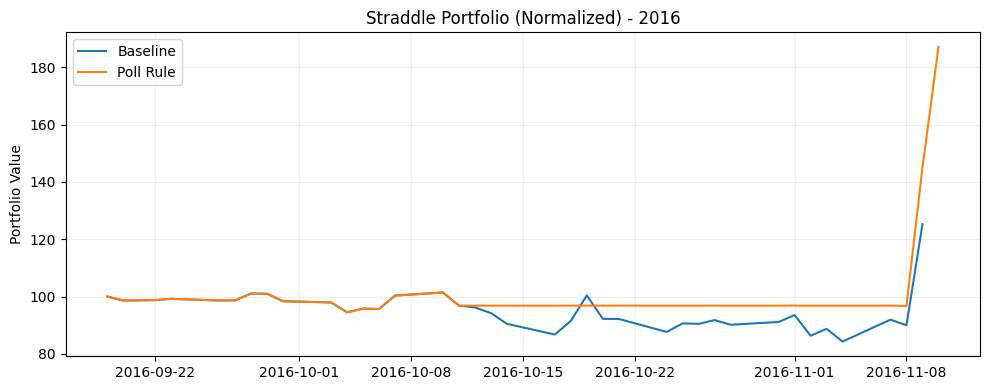

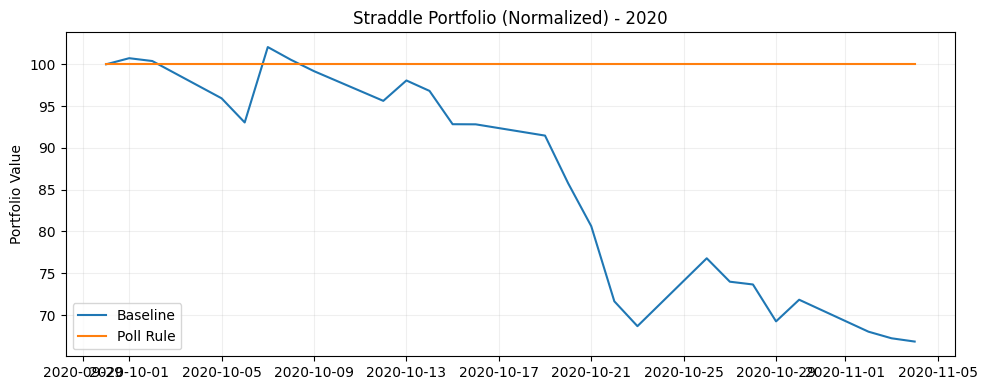

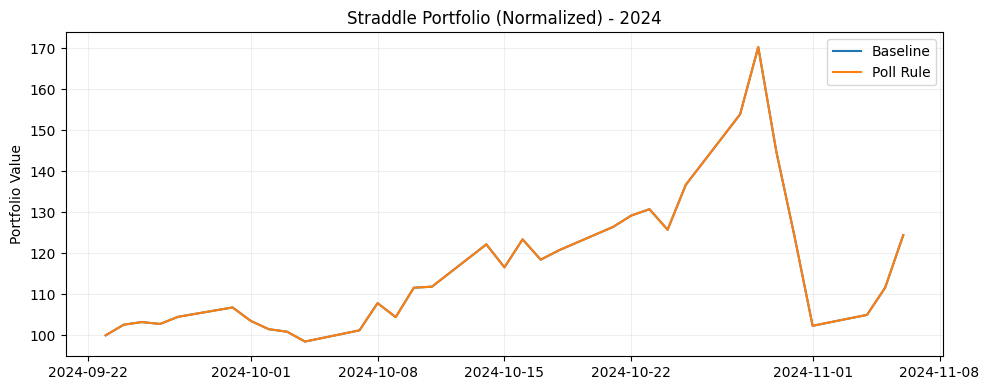

In [224]:
# Poll-rule straddle strategy using signal dates (compare vs baseline)
poll_returns = {}
poll_daily = {}


def next_trading_day(idx_for_signals, d):
    pos = idx.searchsorted(pd.to_datetime(d), side='left')
    return idx[pos] if pos < len(idx) else None


# reentry option files (2016 only)
reentry_dir = Path('../data/optiondata/reentry')
reentry_option_files = {}
for p in reentry_dir.glob('price-history-for-*_*.csv'):
    if ' (1)' in p.name:
        continue
    m = pattern.search(p.name)
    if not m:
        continue
    ticker = m.group('ticker')
    expiry = pd.to_datetime(m.group('expiry'), format='%Y%m%d')
    cp = m.group('cp')
    reentry_option_files[(expiry.year, ticker, cp)] = p

for y in [2016, 2020, 2024]:

    entry_date = entry_by_year.get(y)
    exit_date = exit_by_year.get(y)
    if entry_date is None or exit_date is None:
        continue

    tickers = tickers_by_year.get(y, [])
    daily_series = {}
    signal_series = {}
    for ticker in tickers:
        tk = ticker.lower()
        call_path = option_files.get((y, tk, 'c'))
        put_path = option_files.get((y, tk, 'p'))
        if call_path is None or put_path is None:
            continue
        call_df = load_option_df(call_path)
        put_df = load_option_df(put_path)
        s = daily_straddle_series(call_df, put_df, entry_date, exit_date, col=POLL_HOLD_PRICE_COL)
        if s.empty:
            continue
        daily_series[ticker] = s
    # manual_override_2016: baseline exit, flat, reentry from reentry folder
    if y == 2016:
        exit_target = pd.to_datetime('2016-10-11')
        reentry_target = pd.to_datetime('2016-11-07')
        final_exit_target = pd.to_datetime('2016-11-10')
        base_series = year_daily.get(2016)
        base_value = 100.0
        base_exit_series = pd.Series(dtype=float)
        flat_series = pd.Series(dtype=float)
        if base_series is not None and len(base_series) > 0:
            s_base = base_series.dropna()
            s_exit = s_base.loc[s_base.index <= exit_target]
            if len(s_exit) == 0:
                s_exit = s_base
            base_value = float(s_exit.iloc[-1])
            base_exit_series = s_exit
            flat_end = reentry_target - pd.Timedelta(days=1)
            flat_idx = s_base.loc[(s_base.index > exit_target) & (s_base.index <= flat_end)].index
            if len(flat_idx) > 0:
                flat_series = pd.Series(base_value, index=flat_idx, name='portfolio')
        else:
            base_exit_series = pd.Series([base_value], index=[exit_target], name='portfolio')

        reentry_series = {}
        for ticker in tickers:
            tk = ticker.lower()
            call_path = reentry_option_files.get((y, tk, 'c'))
            put_path = reentry_option_files.get((y, tk, 'p'))
            if call_path is None or put_path is None:
                continue
            call_df = load_option_df(call_path)
            put_df = load_option_df(put_path)
            s = daily_straddle_series(call_df, put_df, reentry_target, final_exit_target, col='Latest')
            if s.empty:
                continue
            reentry_series[ticker] = s

        reentry_value_series = pd.Series(dtype=float)
        if reentry_series:
            prices_df = pd.DataFrame(reentry_series).dropna(how='all')
            prices_df = prices_df.dropna()
            if not prices_df.empty:
                idx = prices_df.index
                n = len(prices_df.columns)
                shares = {t: 0.0 for t in prices_df.columns}
                capital = base_value
                vals = []
                for day in idx:
                    if day == idx[0]:
                        for t in prices_df.columns:
                            price = float(prices_df.loc[day, t])
                            shares[t] = (capital / n) / price if price > 0 else 0.0
                    capital = sum(float(prices_df.loc[day, t]) * shares[t] for t in prices_df.columns)
                    vals.append(capital)
                reentry_value_series = pd.Series(vals, index=idx, name='portfolio')

        combined = pd.concat([base_exit_series, flat_series, reentry_value_series]).sort_index()
        combined = combined[~combined.index.duplicated(keep='last')]
        poll_daily[y] = combined
        s = combined.dropna()
        if len(s) > 1 and s.iloc[0] != 0:
            poll_returns[y] = (s.iloc[-1] / s.iloc[0] - 1) * 100
        else:
            poll_returns[y] = 0.0
        continue
    if not daily_series:
        poll_returns[y] = 0.0
        base_series = year_daily.get(y)
        if base_series is not None and len(base_series) > 0:
            poll_daily[y] = pd.Series(100.0, index=base_series.index, name='portfolio')
        else:
            poll_daily[y] = pd.Series([100.0], index=[entry_date], name='portfolio')
        continue

    prices_df = pd.DataFrame(daily_series)
    base_idx = prices_df.index
    signal_prices_df = None
    if signal_series:
        signal_prices_df = pd.DataFrame(signal_series)
        signal_prices_df = signal_prices_df.reindex(base_idx)
    window_start = base_idx.min()
    window_end = pd.to_datetime(exit_date)
    idx_for_signals = base_idx

    df_sig = signal_table.get(y)
    exit_days = set()
    reentry_day = None
    reentry_prices_df = None
    idx = base_idx
    if reentry_prices_df is not None:
        idx = idx.union(reentry_prices_df.index).sort_values()

    if df_sig is not None and not df_sig.empty:
        exit_trade_dates = pd.to_datetime(
            df_sig.loc[df_sig['signal_type'] == 'exit', 'trading_date']
        ).dropna()
        exit_days = set()
        for d in exit_trade_dates:
            nd = next_trading_day(idx_for_signals, d)
            if nd is not None and window_start <= nd <= window_end:
                exit_days.add(nd)

        if y == 2016:
            re_list = pd.to_datetime(
                df_sig.loc[df_sig['signal_type'] == 'reentry', 'trading_date']
            ).dropna()
            if len(re_list) > 0:
                cand = next_trading_day(idx, re_list.iloc[0])
                if cand is not None and window_start <= cand <= window_end:
                    reentry_day = cand

    if y == 2016 and reentry_day is not None:
        reentry_series = {}
        reentry_signal_series = {}
        for ticker in tickers:
            tk = ticker.lower()
            call_path = reentry_option_files.get((y, tk, 'c'))
            put_path = reentry_option_files.get((y, tk, 'p'))
            if call_path is None or put_path is None:
                continue
            call_df = load_option_df(call_path)
            put_df = load_option_df(put_path)
            s = daily_straddle_series(call_df, put_df, reentry_day, exit_date, col=POLL_HOLD_PRICE_COL)
            if s.empty:
                continue
            reentry_series[ticker] = s
            s_signal = daily_straddle_series(call_df, put_df, reentry_day, exit_date, col='Latest')
            if not s_signal.empty:
                reentry_signal_series[ticker] = s_signal
        if reentry_series:
            reentry_prices_df = pd.DataFrame(reentry_series)
        if reentry_signal_series:
            reentry_signal_prices_df = pd.DataFrame(reentry_signal_series)

    start_day = base_idx.min()

    n = len(prices_df.columns)
    shares = {t: 0.0 for t in prices_df.columns}
    capital = 100.0
    invested = False
    reentry_active = False
    vals = []
    for day in idx:
        if not invested and day == start_day:
            for t in prices_df.columns:
                price = float(prices_df.loc[day, t])
                shares[t] = (capital / n) / price if price > 0 else 0.0
            invested = True

        if reentry_day is not None and day == reentry_day and reentry_prices_df is not None:
            if invested:
                capital = sum(float(prices_df.loc[day, t]) * shares[t] for t in prices_df.columns)
            for t in prices_df.columns:
                shares[t] = 0.0
            for t in prices_df.columns:
                if t in reentry_prices_df.columns and day in reentry_prices_df.index:
                    price = float(reentry_prices_df.loc[day, t])
                else:
                    price = float(prices_df.loc[day, t])
                shares[t] = (capital / n) / price if price > 0 else 0.0
            invested = True
            reentry_active = True

        if invested and day in exit_days:
            capital = sum(float(prices_df.loc[day, t]) * shares[t] for t in prices_df.columns)
            for t in prices_df.columns:
                shares[t] = 0.0
            invested = False

        if invested:
            total = 0.0
            for t in prices_df.columns:
                if reentry_active and reentry_prices_df is not None and t in reentry_prices_df.columns and day in reentry_prices_df.index:
                    price = float(reentry_prices_df.loc[day, t])
                else:
                    price = float(prices_df.loc[day, t])
                total += price * shares[t]
            capital = total
        vals.append(capital)

    series = pd.Series(vals, index=idx, name='portfolio')
    poll_daily[y] = series
    s = series.dropna()
    if len(s) > 1 and s.iloc[0] != 0:
        poll_returns[y] = (s.iloc[-1] / s.iloc[0] - 1) * 100
    else:
        poll_returns[y] = 0.0

compare_rows = []
for y in [2016, 2020, 2024]:
    base_ret = None
    if y in year_daily:
        s = year_daily[y].dropna()
        if len(s) > 1 and s.iloc[0] != 0:
            base_ret = (s.iloc[-1] / s.iloc[0] - 1) * 100
        elif len(s) > 0:
            base_ret = 0.0
    compare_rows.append({
        'year': y,
        'Baseline_Return_%': base_ret,
        'PollRule_Return_%': poll_returns.get(y),
    })
compare_df = pd.DataFrame(compare_rows)
if not compare_df.empty:
    compare_df = compare_df.set_index('year')
display(compare_df)

def rebase_to_100(s):
    s = s.dropna()
    if len(s) == 0:
        return s
    base = s.iloc[0]
    if base == 0:
        return s
    return (s / base) * 100

for y in sorted(year_daily.keys()):
    if y not in poll_daily:
        continue
    plt.figure(figsize=(10, 4))
    base_plot = rebase_to_100(year_daily[y])
    poll_plot = rebase_to_100(poll_daily[y])
    if poll_plot.empty and not base_plot.empty:
        poll_plot = pd.Series(100.0, index=base_plot.index, name='portfolio')
    plt.plot(base_plot.index, base_plot.values, label='Baseline')
    plt.plot(poll_plot.index, poll_plot.values, label='Poll Rule')
    plt.title(f'Straddle Portfolio (Normalized) - {y}')
    plt.ylabel('Portfolio Value')
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()




